# Machine Learning A4
#### Author: Logan Fouts (lf222yv)
## Exercise 1: Clustering

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans


def sse(cluster):
    """
    Calculates the SSE for given cluster.

    Params:
        cluster (np array): The cluster in which to find the SSE.
    
    Return:
        float: SSE value for the cluster.
    """
    clustMean = np.mean(cluster, axis=0)
    squareErr = (cluster - clustMean) ** 2
    sse = np.sum(squareErr)

    return sse


def bkmeans(X, k, iter):
    """
    Executes Bisecting k-means clustering with provided arguments.

    Parameters:
        X (numpy array): Data to perform clustering on.
        k (int): Number of differnt clusters to seperate out.
        iter (int): Number of times to iterate inside of K means.
    Return:
        numpy array: n x 1 vector with cluster indices for each of the observations.
    """
    # Single cluster containing all observations.
    clusters = [X]

    # Bisecting k-Means.
    while len(clusters) < k:
        # Find cluster with the largest SSE.
        largestSSE_cluster = clusters[0]
        largestSSE = sse(clusters[0])

        for cluster in clusters[1:]:
            tmpSSE = sse(cluster)
            if tmpSSE > largestSSE:
                largestSSE = tmpSSE
                largestSSE_cluster = cluster
        
        # K-Means on the cluster from above.
        kmeans = KMeans(n_clusters=2, n_init=iter)
        kmeans.fit(largestSSE_cluster)
        labels = kmeans.labels_
        
        # Split into two clusters.
        subClust1 = largestSSE_cluster[labels == 0]
        subClust2 = largestSSE_cluster[labels == 1]
        
        # Remove largest cluster add two subclusters.
        tmp_clusters = []
        for cluster in clusters:
            if not np.array_equal(cluster, largestSSE_cluster):
                tmp_clusters.append(cluster)
        clusters = tmp_clusters
        clusters.append(subClust1)
        clusters.append(subClust2)

    # Assign cluster indices for data points.
    cluster_indices = np.zeros(X.shape[0])
    for i, cluster in enumerate(clusters):
        indices = np.isin(X, cluster).all(axis=1)
        cluster_indices[indices] = i

    return cluster_indices.reshape([-1, 1])

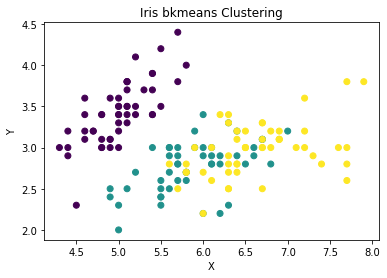

In [3]:
################################ Testing ################################
iris = datasets.load_iris()
X = iris.data

k = 3
iterations = 10
cluster_indices = bkmeans(X, k, iterations)

plt.scatter(X[:, 0], X[:, 1], c=cluster_indices)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Iris bkmeans Clustering')
plt.show()

## Exercise 2: Non-linear Dimensionality Reduction

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets


def compute_gradient(Y, X):
    """
    Calculates the gradient for a given sammon mapping.

    Arguments:
        Y (numpy array): Config of points.
        data (numpy array): Original points.

    Return:
        numpy array: Gradient of sammon mapping.
    """
    s = Y.shape[0]
    distY = np.sqrt(np.sum((Y[:, np.newaxis] - Y) ** 2, axis=2))
    distD = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=2))
    grade = np.zeros(Y.shape)
    
    for i in range(s):
        tmpY = Y[i] - Y
        dataChange = X[i] - X
        tmpY[i] = 0
        dataChange[i] = 0
        # Be careful with division by zero.
        deriveE = (distY[i] - distD[i]) / ((distY[i] * distD[i]) + 1e-8)
        grade[i] = np.sum(tmpY * deriveE[:, np.newaxis], axis=0)

    return (grade * (2 / s))

def compute_stress(Y, X):
    """
    Computes stress for given sammon mapping.

    Arguments:
        Y (numpy array): Config of points.
        data (numpy array): Original points.

    Return:
        float: Current stress of sammon mapping.
    """
    distY = np.linalg.norm(Y[:, np.newaxis] - Y, axis=2)
    distD = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    stress = np.mean((distY - distD) ** 2)

    return stress

def sammon(X, iter=500, e=1e-7, a=.1):
    """
    Implements sammon mapping given a set of data and optionally 3 other parameters.

    Arguments:
        X (numpy array): Data to reduce, as an n x p matrix (n observations by p features).
        iter (int): Maximum number of iterations.
        e (float): Error threshold.
        a (float): Learning rate.
    
    Return:
        numpy array: A n x 2 vector with the final two-dimensional layout.
    """
    # 1. Start with a random two-dimensional layout Y of points (Y is a n × 2 matrix).
    Y = np.random.rand(X.shape[0], 2)

    # 2. Compute the stress E of Y.
    E = compute_stress(Y, X)

    # 3. If E < epsilon, or if the maximum number of iterations iterations has been reached, stop.
    for i in range(iter):
        if E < e:
            break
    # 4. For each yi of Y, find the next vector yi(t + 1) based on the current yi(t).
        gradient = compute_gradient(Y, X)
        Y -= a * gradient
        E = compute_stress(Y, X)
    
    return Y

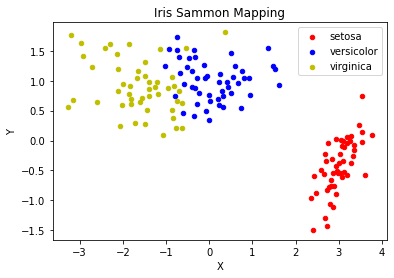

In [5]:
################################ Testing ################################
iris = datasets.load_iris()
(x,index) = np.unique(iris.data,axis=0,return_index=True)
target = iris.target[index]
names = iris.target_names
np.random.seed(0)

iter = 100
e = 1e-7
a = 1
y = sammon(x, iter, e, a)

plt.scatter(y[target ==0, 0], y[target ==0, 1], s=20, c='r',label=names[0])
plt.scatter(y[target ==1, 0], y[target ==1, 1], s=20, c='b',label=names[1])
plt.scatter(y[target ==2, 0], y[target ==2, 1], s=20, c='y',label=names[2])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Iris Sammon Mapping')
plt.show()

## Exercise 3: Visualization of Results
### 3.1 (Comparison of DR Techniques)

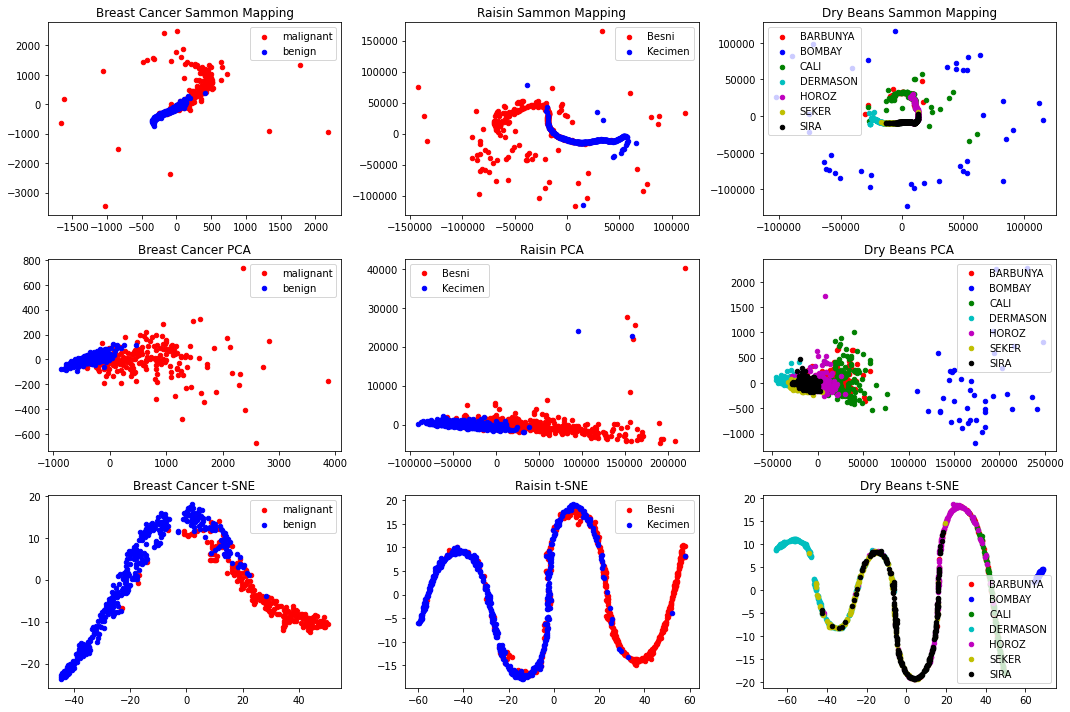

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Datasets
subset_size = 1000

bc = datasets.load_breast_cancer()
(bcX, index) = np.unique(bc.data, axis=0, return_index=True)
bcTarget = bc.target[index]
bcNames = bc.target_names

data = pd.read_excel("Data/Raisin_Dataset.xlsx")
raisinX = data.drop("Class", axis=1).values
raisinTarget = data["Class"].values

data = pd.read_excel("Data/Dry_Bean_Dataset.xlsx")
beanSubset = data.sample(n=subset_size, random_state=42)
beanX = beanSubset.drop("Class", axis=1).values
beanTarget = beanSubset["Class"].values

# Run Sammon Mapping for each dataset
iter = 100
e = 1e-7
a = 100
bcResult = sammon(bcX, iter, e, a)
iter = 100
e = 1e-7
a = 2000
raisinResult = sammon(raisinX, iter, e, a)
iter = 100
e = 1e-7
a = 1000
beanResult = sammon(beanX, iter, e, a)

# Run PCA for each dataset
pca = PCA(n_components=2)
bcPcaResult = pca.fit_transform(bcX)
raisinPcaResult = pca.fit_transform(raisinX)
beanPcaResult = pca.fit_transform(beanX)

# Run t-SNE for each dataset
tsne = TSNE(n_components=2, random_state=42)
bcTsneResult = tsne.fit_transform(bcX)
raisinTsneResult = tsne.fit_transform(raisinX)
beanTsneResult = tsne.fit_transform(beanX)

############################## Plotting ##############################

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

########## Sammon Mapping ##########

axs[0, 0].scatter(bcResult[bcTarget == 0, 0], bcResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[0, 0].scatter(bcResult[bcTarget == 1, 0], bcResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[0, 0].set_title('Breast Cancer Sammon Mapping')
axs[0, 0].legend()

targetClasses = np.unique(raisinTarget)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[0, 1].scatter(raisinResult[indices, 0], raisinResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[0, 1].set_title('Raisin Sammon Mapping')
axs[0, 1].legend()

target_labels = np.unique(beanTarget)
for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[0, 2].scatter(beanResult[indices, 0], beanResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[0, 2].set_title('Dry Beans Sammon Mapping')
axs[0, 2].legend()

########## PCA ##########

axs[1, 0].scatter(bcPcaResult[bcTarget == 0, 0], bcPcaResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[1, 0].scatter(bcPcaResult[bcTarget == 1, 0], bcPcaResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[1, 0].set_title('Breast Cancer PCA')
axs[1, 0].legend()

for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[1, 1].scatter(raisinPcaResult[indices, 0], raisinPcaResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[1, 1].set_title('Raisin PCA')
axs[1, 1].legend()

for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[1, 2].scatter(beanPcaResult[indices, 0], beanPcaResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[1, 2].set_title('Dry Beans PCA')
axs[1, 2].legend()

########## t-SNE ##########

axs[2, 0].scatter(bcTsneResult[bcTarget == 0, 0], bcTsneResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[2, 0].scatter(bcTsneResult[bcTarget == 1, 0], bcTsneResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[2, 0].set_title('Breast Cancer t-SNE')
axs[2, 0].legend()

for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[2, 1].scatter(raisinTsneResult[indices, 0], raisinTsneResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[2, 1].set_title('Raisin t-SNE')
axs[2, 1].legend()

for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[2, 2].scatter(beanTsneResult[indices, 0], beanTsneResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[2, 2].set_title('Dry Beans t-SNE')
axs[2, 2].legend()

plt.tight_layout()
plt.show()